In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets

import matplotlib.pyplot as plt
%matplotlib inline

2021-08-11 23:40:54.219576: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
%load_ext tensorboard

In [3]:
num_epochs = 10
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

In [19]:
train_paths = glob('dataset/cifar/train/*.png')
test_paths = glob('dataset/cifar/train/*.png')

path = train_paths[0]

In [20]:
def get_class_name(path):
    fname = tf.strings.split(path, '_')[-1]
    class_name = tf.strings.regex_replace(fname, '.png', '')
    return class_name

train_labels = [get_class_name(path) for path in train_paths]
class_names = tf.unique(train_labels).y.numpy()

In [21]:
def get_label(path):
    lbl_name = get_class_name(path)
    onehot_encoding = tf.cast(class_names == lbl_name, tf.uint8)
    return tf.argmax(onehot_encoding)

def load_image_label(path):
    # image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    # normalization
    image = tf.cast(image, tf.float32) / 255.

    #label
    label = get_label(path)
    return image, label

def image_preprocessing(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocessing, num_parallel_calls=AUTOTUNE) # transformed
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [24]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

## Callbacks - Tensorboard

In [16]:
starttime = datetime.now()
starttime

datetime.datetime(2021, 8, 11, 22, 8, 28, 245259)

In [12]:
logdir = os.path.join('logs', datetime.now().strftime('%Y%m%d-%H%M%S'))

In [13]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                             write_graph=True,
                                             write_images=True,
                                             histogram_freq=1)

2021-08-11 23:41:56.968590: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-08-11 23:41:56.968631: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 2 GPUs
2021-08-11 23:41:56.969136: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so.10.1
2021-08-11 23:41:57.069551: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


In [14]:
%tensorboard --logdir logs

## Training

In [15]:
inputs = layers.Input((32, 32, 3))

net = layers.Conv2D(32, (3, 3), padding='SAME', activation='relu')(inputs)
net = layers.Conv2D(32, (3, 3), padding='SAME', activation='relu')(net)
net = layers.MaxPooling2D((2,2))(net)
net = layers.Dropout(0.2)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME', activation='relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME', activation='relu')(net)
net = layers.MaxPooling2D((2,2))(net)
net = layers.Dropout(0.2)(net)

net = layers.Flatten()(net)
net = layers.Dense(512, activation='relu')(net)
net = layers.Dropout(0.2)(net)
net = layers.Dense(10, activation='softmax')(net)

model = tf.keras.Model(inputs=inputs,
                      outputs=net,
                      name='Basic_CNN')

# model.summary()

In [16]:
loss = 'sparse_categorical_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']

In [17]:
model.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)

In [25]:
hist = model.fit_generator(train_dataset,
                          steps_per_epoch=len(train_paths) // batch_size,
                          epochs=num_epochs,
                          validation_data=test_dataset,
                          validation_steps=len(test_paths) // batch_size,
                          callbacks=[tensorboard]
                          )

Epoch 1/10
   1/1562 [..............................] - ETA: 1s - loss: 1.3442 - accuracy: 0.4688WARNING:tensorflow:From /home/ziippy/venv_tf2/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
  73/1562 [>.............................] - ETA: 4s - loss: 1.7462 - accuracy: 0.3652

2021-08-11 23:45:15.070784: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-08-11 23:45:15.071438: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2021-08-11 23:45:15.079538: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-08-11 23:45:15.086331: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/20210811-234156/train/plugins/profile/2021_08_11_23_45_15
2021-08-11 23:45:15.087664: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/20210811-234156/train/plugins/profile/2021_08_11_23_45_15/V6.trace.json.gz
2021-08-11 23:45:15.093474: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/

1562/1562 [==============================] - 5s 3ms/step - loss: 1.4436 - accuracy: 0.4750 - val_loss: 1.1590 - val_accuracy: 0.5817
Epoch 2/10
1562/1562 [==============================] - 5s 3ms/step - loss: 1.1484 - accuracy: 0.5864 - val_loss: 1.0141 - val_accuracy: 0.6384
Epoch 3/10
1562/1562 [==============================] - 5s 3ms/step - loss: 1.0201 - accuracy: 0.6373 - val_loss: 0.8748 - val_accuracy: 0.6938
Epoch 4/10
1562/1562 [==============================] - 5s 3ms/step - loss: 0.9533 - accuracy: 0.6614 - val_loss: 0.8438 - val_accuracy: 0.7034
Epoch 5/10
1562/1562 [==============================] - 5s 3ms/step - loss: 0.8929 - accuracy: 0.6821 - val_loss: 0.7569 - val_accuracy: 0.7359
Epoch 6/10
1562/1562 [==============================] - 5s 3ms/step - loss: 0.8526 - accuracy: 0.6985 - val_loss: 0.7375 - val_accuracy: 0.7394
Epoch 7/10
1562/1562 [==============================] - 5s 3ms/step - loss: 0.8199 - accuracy: 0.7108 - val_loss: 0.7194 - val_accuracy: 0.7477
Epo

## Confusion Matrix

In [43]:
import io
import itertools
import sklearn.metrics

file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

In [37]:
def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model.predict(test_images)
  test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
  cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [44]:
test_images, test_labels = next(iter(test_dataset))

hist = model.fit_generator(train_dataset,
                          steps_per_epoch=len(train_paths) // batch_size,
                          epochs=num_epochs,
                          validation_data=test_dataset,
                          validation_steps=len(test_paths) // batch_size,
                          callbacks=[tensorboard, cm_callback]
                          )

Epoch 1/10
  57/1562 [>.............................] - ETA: 4s - loss: 0.6239 - accuracy: 0.7747

2021-08-12 00:05:23.031330: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-08-12 00:05:23.031412: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-08-12 00:05:23.035884: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-08-12 00:05:23.039961: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/20210811-234156/train/plugins/profile/2021_08_12_00_05_23
2021-08-12 00:05:23.041698: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/20210811-234156/train/plugins/profile/2021_08_12_00_05_23/V6.trace.json.gz
2021-08-12 00:05:23.045441: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/20210811

1562/1562 [==============================] - 7s 5ms/step - loss: 0.6436 - accuracy: 0.7731 - val_loss: 0.4773 - val_accuracy: 0.8336
Epoch 2/10
1562/1562 [==============================] - 6s 4ms/step - loss: 0.6363 - accuracy: 0.7748 - val_loss: 0.4748 - val_accuracy: 0.8359
Epoch 3/10
1562/1562 [==============================] - 6s 4ms/step - loss: 0.6207 - accuracy: 0.7793 - val_loss: 0.4976 - val_accuracy: 0.8294
Epoch 4/10
1562/1562 [==============================] - 6s 4ms/step - loss: 0.6160 - accuracy: 0.7826 - val_loss: 0.4645 - val_accuracy: 0.8376
Epoch 5/10
1562/1562 [==============================] - 5s 4ms/step - loss: 0.6009 - accuracy: 0.7885 - val_loss: 0.4257 - val_accuracy: 0.8525
Epoch 6/10
1562/1562 [==============================] - 5s 3ms/step - loss: 0.5970 - accuracy: 0.7917 - val_loss: 0.4410 - val_accuracy: 0.8474
Epoch 7/10
1562/1562 [==============================] - 5s 3ms/step - loss: 0.5888 - accuracy: 0.7933 - val_loss: 0.4239 - val_accuracy: 0.8548
Epo

## Callbacks - Learning Rate Scheduler

In [45]:
import math

def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * math.exp(0.1 * (10 - epoch))

In [46]:
for epoch in range(10, 20):
    print(0.001 * math.exp(0.1 * (10 - epoch)))

0.001
0.0009048374180359595
0.0008187307530779819
0.0007408182206817179
0.0006703200460356394
0.0006065306597126335
0.0005488116360940264
0.0004965853037914095
0.0004493289641172216
0.00040656965974059914


In [49]:
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [50]:
hist = model.fit_generator(train_dataset,
                          steps_per_epoch=len(train_paths) // batch_size,
                          epochs=20,
                          validation_data=test_dataset,
                          validation_steps=len(test_paths) // batch_size,
                          callbacks=[tensorboard, learning_rate_scheduler]
                          )


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/20
  57/1562 [>.............................] - ETA: 4s - loss: 0.3994 - accuracy: 0.8596

2021-08-13 12:28:49.777935: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-08-13 12:28:49.777984: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-08-13 12:28:49.782760: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-08-13 12:28:49.785352: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/20210811-234156/train/plugins/profile/2021_08_13_12_28_49
2021-08-13 12:28:49.787048: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/20210811-234156/train/plugins/profile/2021_08_13_12_28_49/V6.trace.json.gz
2021-08-13 12:28:49.790835: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/20210811

1562/1562 [==============================] - 5s 3ms/step - loss: 0.4441 - accuracy: 0.8425 - val_loss: 0.2749 - val_accuracy: 0.9099

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/20
1562/1562 [==============================] - 5s 3ms/step - loss: 0.4477 - accuracy: 0.8432 - val_loss: 0.2497 - val_accuracy: 0.9154

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/20
1562/1562 [==============================] - 5s 3ms/step - loss: 0.4569 - accuracy: 0.8410 - val_loss: 0.2656 - val_accuracy: 0.9131

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/20
1562/1562 [==============================] - 5s 3ms/step - loss: 0.4590 - accuracy: 0.8383 - val_loss: 0.2751 - val_accuracy: 0.9057

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/20
1562/1562 [==============================] - 5s 3ms/step - loss: 0.4614 - accuracy: 0.8386 - val_loss: 0.2463 - val_accuracy: 0.9218

Epoch 00006: L

## Callbacks - checkpoint

In [52]:
save_path = 'checkpoints'

In [56]:
checkpoints = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_accuracy', verbose=1, save_best_only=True)

In [57]:
hist = model.fit_generator(train_dataset,
                          steps_per_epoch=len(train_paths) // batch_size,
                          epochs=num_epochs,
                          validation_data=test_dataset,
                          validation_steps=len(test_paths) // batch_size,
                          callbacks=[tensorboard, checkpoints]
                          )

Epoch 1/10
  55/1562 [>.............................] - ETA: 4s - loss: 0.2912 - accuracy: 0.9019

2021-08-13 12:36:29.679888: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-08-13 12:36:29.679938: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-08-13 12:36:29.684752: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-08-13 12:36:29.687921: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/20210811-234156/train/plugins/profile/2021_08_13_12_36_29
2021-08-13 12:36:29.689367: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/20210811-234156/train/plugins/profile/2021_08_13_12_36_29/V6.trace.json.gz
2021-08-13 12:36:29.693854: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/20210811

1538/1562 [============================>.] - ETA: 0s - loss: 0.2708 - accuracy: 0.9045
Epoch 00001: val_accuracy improved from -inf to 0.97115, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets
1562/1562 [==============================] - 6s 4ms/step - loss: 0.2708 - accuracy: 0.9045 - val_loss: 0.1000 - val_accuracy: 0.9712
Epoch 2/10
1541/1562 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.9049
Epoch 00002: val_accuracy improved from 0.97115 to 0.97295, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets
1562/1562 [==============================] - 6s 4ms/step - loss: 0.2687 - accuracy: 0.9048 - val_loss: 0.0956 - val_accuracy: 0.9730
Epoch 3/10
1558/1562 [============================>.] - ETA: 0s - loss: 0.2623 - accuracy: 0.9078
Epoch 00003: val_accuracy improved from 0.97295 to 0.97407, saving model to checkpoints
INFO:tensorflow:Assets written to: checkpoints/assets
1562/1562 [=================

## History

In [58]:
hist

In [59]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [60]:
hist.params

{'verbose': 1, 'epochs': 10, 'steps': 1562}

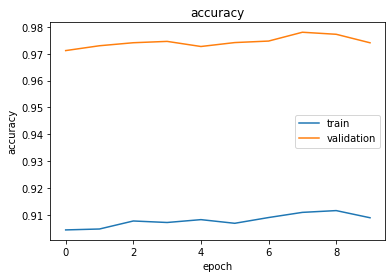

In [64]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

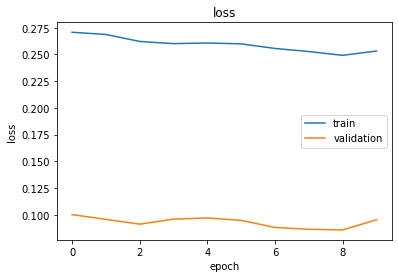

In [65]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

## Predict

In [66]:
path

'dataset/cifar/train/39769_automobile.png'

In [75]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)
image.shape

TensorShape([32, 32, 3])

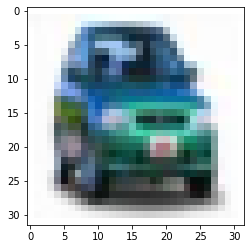

In [76]:
plt.imshow(image, 'gray')

In [69]:
image = image[tf.newaxis, ...]
image.shape

TensorShape([1, 32, 32, 3])

In [70]:
pred = model.predict(image)

In [71]:
pred.shape

(1, 10)

In [72]:
pred

array([[9.9019241e-01, 5.3823970e-14, 5.6703807e-17, 3.1426755e-14,
        7.7125425e-15, 7.5301880e-19, 7.6586688e-19, 2.0413661e-17,
        2.7469148e-11, 9.8075708e-03]], dtype=float32)

In [74]:
np.argmax(pred)

0

In [78]:
preds = model.predict_generator(test_dataset.take(1))

In [79]:
preds.shape

(32, 10)

## Saving Model

In [92]:
save_path = 'my_model.h5'

model.save(save_path, include_optimizer=True)

In [93]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)
image = image[tf.newaxis, ...]
image.shape

model2 = tf.keras.models.load_model(save_path)
pred = model2.predict(image)
pred

array([[9.9019241e-01, 5.3823970e-14, 5.6703807e-17, 3.1426755e-14,
        7.7125425e-15, 7.5301880e-19, 7.6586688e-19, 2.0413661e-17,
        2.7469148e-11, 9.8075708e-03]], dtype=float32)

In [94]:
model.save_weights('my_model_weights.h5')

In [95]:
with open('my_model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [96]:
with open('my_model_architecture.json', 'r') as f:
    model3 = tf.keras.models.model_from_json(f.read())

In [97]:
pred = model3.predict(image)
pred

array([[0.09365011, 0.10370103, 0.08272335, 0.1275218 , 0.10650753,
        0.09592701, 0.10404394, 0.10492016, 0.09909347, 0.08191156]],
      dtype=float32)

In [98]:
model3.load_weights('my_model_weights.h5')

In [99]:
pred = model3.predict(image)
pred

array([[9.9019241e-01, 5.3823970e-14, 5.6703807e-17, 3.1426755e-14,
        7.7125425e-15, 7.5301880e-19, 7.6586688e-19, 2.0413661e-17,
        2.7469148e-11, 9.8075708e-03]], dtype=float32)

## H5 

In [100]:
import h5py

In [101]:
model_file = h5py.File('my_model.h5', 'r+')

In [102]:
model_file.keys()

<KeysViewHDF5 ['model_weights', 'optimizer_weights']>

In [104]:
model_file['model_weights'].keys()

<KeysViewHDF5 ['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'dense', 'dense_1', 'dropout', 'dropout_1', 'dropout_2', 'flatten', 'input_1', 'max_pooling2d', 'max_pooling2d_1']>

In [107]:
model_file['model_weights']['conv2d']['conv2d'].keys()

<KeysViewHDF5 ['bias:0', 'kernel:0']>

In [108]:
model_file['model_weights']['conv2d']['conv2d']['kernel:0']

<HDF5 dataset "kernel:0": shape (3, 3, 3, 32), type "<f4">

In [111]:
weights = np.array(model_file['model_weights']['conv2d']['conv2d']['kernel:0'])
weights

array([[[[-7.52552599e-02,  1.50135875e-01, -1.13852464e-01,
          -8.02826956e-02, -1.19651228e-01, -5.99274300e-02,
          -4.61509079e-01,  5.82593493e-02, -4.06266093e-01,
           6.15321286e-02,  6.70740604e-02,  1.55318812e-01,
          -1.73453584e-01, -8.53595510e-02,  1.52793035e-01,
          -1.32364377e-01,  5.89869693e-02, -1.76730350e-01,
          -4.01882082e-02,  1.21903636e-01, -1.38893470e-01,
           1.49289574e-02,  1.00696385e-01, -3.26840170e-02,
          -4.15204853e-01,  3.65340769e-01, -5.19243665e-02,
           5.98017089e-02,  4.77253832e-02, -4.45229970e-02,
           1.63611680e-01,  5.75156836e-03],
         [-8.05613995e-02,  4.07823697e-02,  1.41835222e-02,
           2.88842199e-03,  1.74480915e-01,  6.93672597e-02,
          -4.62025493e-01, -6.52723685e-02,  5.25759533e-02,
           4.00008969e-02,  4.04430814e-02, -5.79109937e-02,
           1.09196559e-01, -4.93818708e-02,  9.39923450e-02,
          -3.35037261e-01, -2.81628162e-